# TensorRider Algorithm

In [1]:
import numpy as np
import tensorflow as tf
import tensorlayer as tl
from matplotlib import pyplot as plt

In [2]:
sess = tf.InteractiveSession()

In [3]:
def preprocess(rgb):
    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
#     mono = 0.2989 * r + 0.5870 * g + 0.1140 * b
#     mono = 0.5 * r + 0.25 * g + 0.25 * b
    rgb = rgb * (1. / 255)
    return rgb

In [4]:
def prepareDataArrays(iterator):
    X = np.empty((0, 14400))
    y = np.empty((0,1))
    X_buffer = np.empty((0, 14400))
    y_buffer = np.empty((0,1))
    
    recordCounter = 0;

    for string_record in iterator:
        recordCounter += 1

        example = tf.train.Example()
        example.ParseFromString(string_record)
        imageString = (example.features.feature['image'].bytes_list.value[0])
        label = (example.features.feature['label'].int64_list.value[0])
        
        image = np.fromstring(imageString, dtype=np.uint8)
        image = image.reshape((60, 80, 3))
        image = preprocess(image)
        image = image.reshape((14400))

        X_buffer = np.append(X_buffer, [image], axis=0)
        y_buffer = np.append(y_buffer, label)
        
        if recordCounter % 100 == 0:
            print(recordCounter,end = '->')
        if recordCounter % 1000 == 0:
            print("Merging")
            X = np.append(X, [X_buffer])
            y = np.append(y, [y_buffer])
            X_buffer = np.empty((0, 14400))
            y_buffer = np.empty((0,1))
    
    print("Done")        
    X = np.append(X, [X_buffer])
    y = np.append(y, y_buffer)
    
    X = X.reshape((recordCounter, 14400))
    y = y.reshape((recordCounter,))
    y = np.round(y / 6)
    y = y + 7
    return X, y

In [5]:
trainIterator = tf.python_io.tf_record_iterator(path="train.tfrecords")
valIterator = tf.python_io.tf_record_iterator(path="val.tfrecords")

# TFRecords -> Arrays

In [6]:
print("\nTrain...")
X_train, y_train = prepareDataArrays(trainIterator)
print("\nVal...")
X_val, y_val = prepareDataArrays(valIterator)


Train...


D:\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


100->200->300->400->500->600->700->800->900->1000->Merging
1100->1200->1300->1400->1500->1600->1700->1800->1900->2000->Merging
2100->2200->2300->2400->2500->2600->2700->2800->2900->3000->Merging
3100->3200->3300->3400->3500->3600->3700->3800->3900->4000->Merging
4100->4200->4300->4400->4500->4600->4700->4800->4900->5000->Merging
5100->5200->5300->5400->5500->5600->5700->5800->5900->6000->Merging
6100->6200->6300->6400->6500->6600->6700->6800->6900->7000->Merging
7100->7200->7300->7400->7500->7600->7700->7800->7900->8000->Merging
8100->8200->8300->8400->8500->8600->8700->8800->8900->9000->Merging
9100->9200->9300->9400->9500->9600->9700->9800->9900->10000->Merging
10100->10200->10300->10400->10500->10600->10700->10800->10900->11000->Merging
11100->11200->11300->11400->11500->11600->11700->11800->11900->12000->Merging
12100->12200->12300->12400->12500->12600->12700->12800->12900->13000->Merging
13100->13200->13300->13400->13500->13600->13700->13800->13900->14000->Merging
14100->14200->14

# Arrays -> NPZ File

In [7]:
np.savez("arrays_norm.npz", xtr = X_train, ytr = y_train, xval = X_val, yval = y_val)

# NPZ File -> Arrays

In [5]:
npRecall = np.load("arrays_norm.npz")
X_train = npRecall["xtr"]
y_train = npRecall["ytr"]
X_val = npRecall["xval"]
y_val = npRecall["yval"]

(array([6.000e+00, 7.000e+00, 3.000e+00, 3.600e+02, 3.472e+03, 5.902e+03,
        1.929e+03, 8.452e+03, 1.655e+03, 5.032e+03, 2.718e+03, 4.330e+02,
        2.100e+01, 1.000e+01]),
 array([ 0.        ,  0.92857143,  1.85714286,  2.78571429,  3.71428571,
         4.64285714,  5.57142857,  6.5       ,  7.42857143,  8.35714286,
         9.28571429, 10.21428571, 11.14285714, 12.07142857, 13.        ]),
 <a list of 14 Patch objects>)

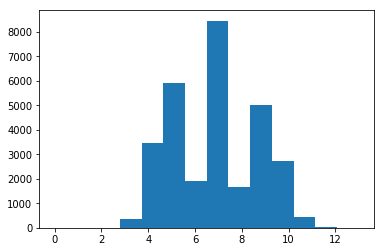

In [6]:
plt.hist(y_train, 14)

# Define the Neural Network

In [6]:
x = tf.placeholder(tf.float32, shape=[None, 14400], name='x')
y_ = tf.placeholder(tf.int64, shape=[None], name='y_')

In [7]:
network = tl.layers.InputLayer(x, name='input')
# network = tl.layers.DropoutLayer(network, keep=0.8, name='drop1')
network = tl.layers.DenseLayer(network, 2048, tf.nn.relu, name='relu1')
network = tl.layers.DenseLayer(network, n_units=15, act=tf.identity, name='output')

[TL] InputLayer  input: (?, 14400)
[TL] DenseLayer  relu1: 2048 relu
[TL] DenseLayer  output: 15 identity


In [8]:
y = network.outputs
cost = tl.cost.cross_entropy(y, y_, name='cost')
correct_prediction = tf.equal(tf.argmax(y, 1), y_)
acc = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

y_op = tf.argmax(tf.nn.softmax(y), 1)

In [9]:
train_params = network.all_params
train_op = tf.train.AdamOptimizer(learning_rate=0.0001).minimize(cost, var_list=train_params)

In [10]:
tl.layers.initialize_global_variables(sess)

In [11]:
network.print_params()

[TL]   param   0: relu1/W:0            (14400, 2048)      float32_ref (mean: 2.6911176973953843e-05, median: 2.246599797217641e-05, std: 0.0879698246717453)   
[TL]   param   1: relu1/b:0            (2048,)            float32_ref (mean: 0.0               , median: 0.0               , std: 0.0               )   
[TL]   param   2: output/W:0           (2048, 15)         float32_ref (mean: -0.00039739918429404497, median: -2.266487354063429e-05, std: 0.08825226128101349)   
[TL]   param   3: output/b:0           (15,)              float32_ref (mean: 0.0               , median: 0.0               , std: 0.0               )   
[TL]   num of params: 29523983


In [12]:
network.print_layers()

[TL]   layer   0: relu1/Relu:0         (?, 2048)          float32
[TL]   layer   1: output/Identity:0    (?, 15)            float32


# (Optional) Setting up TensorBoard

In [13]:
acc_summ = tf.summary.scalar('acc', acc)
cost_summ = tf.summary.scalar('cost', cost)
summary = tf.summary.merge_all()  
writer = tf.summary.FileWriter('./logs')  
writer.add_graph(sess.graph) 

# Start Training

In [16]:
tl.utils.fit(
    sess, network, train_op, cost, X_train, y_train, x, y_, acc=acc, 
    batch_size=73, n_epoch=500, print_freq=5, X_val=X_val, y_val=y_val, eval_train=True, 
    tensorboard=True, tensorboard_epoch_freq=5, tensorboard_weight_histograms=False, tensorboard_graph_vis=False)

[TL] Setting up tensorboard ...
[TL] [!] logs/ exists ...
[TL] Finished! use $tensorboard --logdir=logs/ to start server
[TL] Start training the network ...
[TL] Epoch 1 of 500 took 24.627733s
[TL]    train loss: 2.120676
[TL]    train acc: 0.497494
[TL]    val loss: 2.280711
[TL]    val acc: 0.455882
[TL] Epoch 5 of 500 took 21.437964s
[TL]    train loss: 2.049593
[TL]    train acc: 0.466388
[TL]    val loss: 2.050974
[TL]    val acc: 0.441781
[TL] Epoch 10 of 500 took 21.107062s
[TL]    train loss: 1.240776
[TL]    train acc: 0.591614
[TL]    val loss: 1.465755
[TL]    val acc: 0.573529
[TL] Epoch 15 of 500 took 20.824369s
[TL]    train loss: 1.203863
[TL]    train acc: 0.591881
[TL]    val loss: 1.312479
[TL]    val acc: 0.568896
[TL] Epoch 20 of 500 took 21.129656s
[TL]    train loss: 1.096383
[TL]    train acc: 0.624123
[TL]    val loss: 1.322807
[TL]    val acc: 0.595488
[TL] Epoch 25 of 500 took 21.122957s
[TL]    train loss: 1.209734
[TL]    train acc: 0.586201
[TL]    val loss

[TL]    train acc: 0.829569
[TL]    val loss: 1.374625
[TL]    val acc: 0.575342
[TL] Epoch 275 of 500 took 20.292208s
[TL]    train loss: 0.404721
[TL]    train acc: 0.835984
[TL]    val loss: 1.474006
[TL]    val acc: 0.582796
[TL] Epoch 280 of 500 took 20.758626s
[TL]    train loss: 0.457230
[TL]    train acc: 0.817741
[TL]    val loss: 1.458054
[TL]    val acc: 0.598106
[TL] Epoch 285 of 500 took 20.315818s
[TL]    train loss: 0.420323
[TL]    train acc: 0.836318
[TL]    val loss: 1.506286
[TL]    val acc: 0.571313
[TL] Epoch 290 of 500 took 20.814420s
[TL]    train loss: 0.455539
[TL]    train acc: 0.817908
[TL]    val loss: 1.644323
[TL]    val acc: 0.525584
[TL] Epoch 295 of 500 took 20.302528s
[TL]    train loss: 0.374920
[TL]    train acc: 0.853425
[TL]    val loss: 1.390168
[TL]    val acc: 0.592264
[TL] Epoch 300 of 500 took 20.522734s
[TL]    train loss: 0.358699
[TL]    train acc: 0.866455
[TL]    val loss: 1.453016
[TL]    val acc: 0.562651
[TL] Epoch 305 of 500 took 21.2

KeyboardInterrupt: 

# Save the Trained Model

In [17]:
tl.files.save_npz(network.all_params, name='model_norm.npz')
sess.close()

[TL] [*] model_norm.npz saved


# Load the Trained Model

In [14]:
tl.files.load_and_assign_npz(sess=sess, name='model_norm.npz', network=network)

[TL] [*] Load model_norm.npz SUCCESS!


# Controlling TensorRider Using the Generated Model

In [15]:
import cv2
import urllib.request
import numpy as np
import socket
import threading
from time import ctime,sleep
import string

remoteImage = np.array([])
stream = urllib.request.urlopen('http://192.168.73.73:8080/?action=stream&ignored.mjpg')
bytes = bytes()

In [16]:
def Image_Refreshing_Thread():
    global remoteImage
    global stream
    global bytes
    while True:
        bytes += stream.read(1024)
        a = bytes.find(b'\xff\xd8')
        b = bytes.find(b'\xff\xd9')
        if a != -1 and b != -1:
            jpg = bytes[a:b+2]
            bytes = bytes[b+2:]
            i = cv2.imdecode(np.fromstring(jpg, dtype=np.uint8), cv2.IMREAD_COLOR)
            i = preprocess(i)
            remoteImage = i.reshape((1, 14400))

In [17]:
def Controlling_Thread():
    global remoteImage
    addr=('192.168.73.73',51423)
    s=socket.socket(socket.AF_INET,socket.SOCK_DGRAM)
    while True:
        direction = tl.utils.predict(sess, network, remoteImage, x, y_op, batch_size=None)
        msgCtrl_Udp = str(40) + "," + str((direction[0] - 7) * 11)
#         print(msgCtrl_Udp)
        s.sendto(msgCtrl_Udp.encode('utf-8'), addr)
        sleep(0.1)

In [18]:
RefreshImageThread = threading.Thread(target = Image_Refreshing_Thread)
RefreshImageThread.start()

D:\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if sys.path[0] == '':


In [19]:
ControllingThread = threading.Thread(target = Controlling_Thread)
ControllingThread.start()

D:\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if sys.path[0] == '':
